In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
from scipy.stats import norm
import matplotlib.pyplot as plt

# Define the device (using GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def instance_generator(n):
    '''
    Function that generates hard Knapsack problem instances.
    Input:
        -n: desired size of set of items I, defaulted at 50,000 as we use this number in our study
    Returns:
        -v: array of values for all i items
        -w: array of weights of all i items
    
    ''' 
    v = np.round(norm.rvs(100, 10, size=n))
    w = np.zeros(n)
    for i in range(n):
        w[i] = round(norm.rvs(v[i], 5))
    return v, w

v, w = instance_generator(5)
# Problem size set-up
N = [10]

Max_items = 150

# Capacity constraint function based on the problem size
def W(n):
    return 0.45*np.sum(w[0:n])

capacity = W(N[0])
class NeuralNetworkAgent(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, n_heads=4, n_layers=2, seq_len=1):
        super(NeuralNetworkAgent, self).__init__()

        # Fully connected layers for initial transformation
        self.fc1_1 = nn.Linear(input_dim, hidden_dim)
        self.fc1_2 = nn.Linear(hidden_dim, hidden_dim)

        # Transformer Encoder setup
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=n_heads, dim_feedforward=hidden_dim
        )
        self.transformer = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=n_layers)

        # Fully connected layers after transformer processing
        self.fc2_1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2_2 = nn.Linear(hidden_dim, 1)  # Output a single Q-value per row

        self.relu = nn.ReLU()

    def forward(self, x):
        # Initial transformation
        x = self.relu(self.fc1_1(x))
        x = self.relu(self.fc1_2(x))

        # Transformer expects input of shape (sequence length, batch size, embedding dimension)
        x = x.unsqueeze(1)  # Add sequence length dimension
        x = self.transformer(x)
        x = x.squeeze(1)  # Remove the sequence length dimension

        # Final transformation to output Q-values
        x = self.relu(self.fc2_1(x))
        qvalues = self.fc2_2(x).squeeze(-1)  # Output one Q-value per row

        return qvalues
class Knapsack_environment:
    def __init__(self, v=v, w=w, capacity=capacity):
        self.v = np.concatenate((v, np.zeros(Max_items-len(v))))
        self.w = np.concatenate((w, np.zeros(Max_items-len(v))))
        self.free = capacity
        self.selected = np.zeros(len(v))
        self.reset(len(v))

    def reset(self, N_items):
        v_new, w_new = instance_generator(N_items)
        W_new = W(N_items)

        self.v = np.concatenate((v_new, np.zeros(Max_items-len(v))))
        self.w = np.concatenate((w_new, np.ones(Max_items-len(v))))
        self.ratios =  self.v / self.w
        self.free =  np.concatenate((np.full(N_items, W_new), np.zeros(Max_items-len(v))))
        self.canbeselected =  np.concatenate((np.zeros(N_items), np.ones(Max_items-len(v))))
        return self.get_state()
    
    def get_state(self):
        return np.vstack([self.v, self.w, self.ratios, self.free, self.canbeselected]).T


    def step(self, action):
        #print(action)
        if np.all(self.canbeselected == 1):
            # change epi_finished
            return self.get_state(), 0,  True
        
        if self.canbeselected[action] == 1:
            
            return self.get_state(), -5, False
        
        self.canbeselected[action] = 1
        reward = self.v[action]
        self.free = self.free - np.full(len(self.v), self.w[action])

        
        self.canbeselected[self.w > self.free] = 1
        
        done = np.all(self.canbeselected == 1)
        return self.get_state(), reward, done
    
    
    
        

        

episodes = 100
batch_size = 64
gamma = 0.95  # Discount factor
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 10

env = Knapsack_environment()
agent = NeuralNetworkAgent().to(device)
optimizer = optim.Adam(agent.parameters(), lr=1e-4)

# Save trained agent
Future_agent = NeuralNetworkAgent().to(device)
Future_agent.load_state_dict(agent.state_dict())

batch_index = 0
history_state = []
history_next_state = []
history_action = []
history_reward = []
history_done = []

for episode in range(episodes):
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay)
    # Amount of items included in training
    N_items = 100
    
    # Episode finished?
    epi_finished = False

    total_reward = 0

    # Get a new state
    state_matrix = env.reset(N_items)
    state = torch.FloatTensor(state_matrix).to(device)

    while not epi_finished:
        # Make sure that the random decision is possible, thus only add items that can be selected
        available_items = np.where(state_matrix[:,4] == 0)[0]

        # Epsilon greedy
        if random.random() > epsilon:
            with torch.no_grad():
                q_values = agent.forward(state)
                action = q_values.argmax().item()
        else:
            action = random.choice(available_items)
        
        next_state, reward, epi_finished = env.step(action)
        next_state_matrix = next_state
        next_state = torch.FloatTensor(next_state_matrix).to(device)
        
        history_state.append(state)
        history_next_state.append(next_state)
        history_action.append(action)
        history_reward.append(reward)
        history_done.append(float(epi_finished))
        
        batch_index += 1
        state = next_state
        state_matrix = next_state_matrix

        if batch_index >= batch_size:
            q_valuestates = []
            q_values_next_states = []

            # Manually calculate q_values and next_q_values using your approach
            for q_index in range(batch_index - batch_size, batch_index):
                q_value = agent(history_state[q_index])[history_action[q_index]]
                next_q_value = Future_agent(history_next_state[q_index]).max()

                q_valuestates.append(q_value)
                q_values_next_states.append(next_q_value)

            q_valuestates = torch.stack(q_valuestates).to(device)
            q_values_next_states = torch.stack(q_values_next_states).to(device)

            rewards = torch.tensor(history_reward[-batch_size:], dtype=torch.float32).to(device)
            dones = torch.tensor(history_done[-batch_size:], dtype=torch.float32).to(device)

            # Calculate the target using next_q_values
            with torch.no_grad():
                targets = rewards + (1.0 - dones) * gamma * q_values_next_states

            targets = targets.float()
            loss = nn.MSELoss()(q_valuestates, targets)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.parameters(), max_norm=0.1)
            optimizer.step()

            print(f"Episode {episode} completed. Loss: {loss.item()}")
    
    #print(episode)












c:\Users\stijn\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Episode 29 completed. Loss: 9997.23046875
Episode 30 completed. Loss: 10011.72265625
Episode 30 completed. Loss: 9985.833984375
Episode 31 completed. Loss: 10018.49609375
Episode 31 completed. Loss: 10036.251953125
Episode 32 completed. Loss: 10012.9287109375
Episode 32 completed. Loss: 10000.84765625
Episode 33 completed. Loss: 9989.134765625
Episode 33 completed. Loss: 9993.876953125
Episode 34 completed. Loss: 9994.7109375
Episode 34 completed. Loss: 9959.08984375
Episode 35 completed. Loss: 9942.822265625
Episode 35 completed. Loss: 9947.802734375
Episode 36 completed. Loss: 9931.498046875
Episode 36 completed. Loss: 9884.640625
Episode 37 completed. Loss: 9921.7392578125
Episode 37 completed. Loss: 9939.3486328125
Episode 38 completed. Loss: 9984.7822265625
Episode 38 completed. Loss: 9825.58203125
Episode 38 completed. Loss: 9721.759765625
Episode 38 completed. Loss: 9574.0478515625
Episode 38 completed. Loss: 9544.0625
Episode 39 completed. Loss: 9684.376953125
Episode 39 comple

In [22]:
z , y = instance_generator(5)
x = np.concatenate((z, np.zeros(3)))
print(x)

[101. 114. 106. 106. 102.   0.   0.   0.]


GOING FURTHER WITH TRAINING THE SAME AGENT


In [33]:
optimizer.param_groups[0]['lr'] = 1e-4
episodes = 50
batch_size = 512
gamma = 0.95  # Discount factor
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 10

for episode in range(episodes):
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * episode / epsilon_decay)
    N_items = 10
    
    epi_finished = False
    total_reward = 0

    state_matrix = env.reset(N_items)
    state = torch.FloatTensor(state_matrix).to(device)

    while not epi_finished:
        available_items = np.where(state_matrix[:,4] == 0)[0]
        if random.random() > epsilon:
            with torch.no_grad():
                q_values = agent.forward(state)
                action = q_values.argmax().item()
        else:
            action = random.choice(available_items)
        
        next_state, reward, epi_finished = env.step(action)
        next_state_matrix = next_state
        next_state = torch.FloatTensor(next_state_matrix).to(device)
        
        history_state.append(state)
        history_next_state.append(next_state)
        history_action.append(action)
        history_reward.append(reward)
        history_done.append(float(epi_finished))
        
        batch_index += 1
        state = next_state
        state_matrix = next_state_matrix

        if batch_index >= batch_size:
            q_valuestates = []
            q_values_next_states = []

            # Manually calculate q_values and next_q_values using your approach
            for q_index in range(batch_index - batch_size, batch_index):
                q_value = agent(history_state[q_index])[history_action[q_index]]
                next_q_value = Future_agent(history_next_state[q_index]).max()

                q_valuestates.append(q_value)
                q_values_next_states.append(next_q_value)

            q_valuestates = torch.stack(q_valuestates).to(device)
            q_values_next_states = torch.stack(q_values_next_states).to(device)

            rewards = torch.tensor(history_reward[-batch_size:], dtype=torch.float32).to(device)
            dones = torch.tensor(history_done[-batch_size:], dtype=torch.float32).to(device)

            # Calculate the target using next_q_values
            with torch.no_grad():
                targets = rewards + (1.0 - dones) * gamma * q_values_next_states

            targets = targets.float()
            loss = nn.MSELoss()(q_valuestates, targets)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.parameters(), max_norm=0.1)
            optimizer.step()

            print(f"Episode {episode} completed. Loss: {loss.item()}")
    
    #print(episode)


Episode 0 completed. Loss: 17.356201171875
Episode 0 completed. Loss: 23.80107879638672
Episode 1 completed. Loss: 29.45588493347168
Episode 1 completed. Loss: 22.109804153442383
Episode 2 completed. Loss: 24.77101707458496
Episode 2 completed. Loss: 18.118907928466797
Episode 3 completed. Loss: 24.965024948120117
Episode 3 completed. Loss: 19.18578338623047
Episode 4 completed. Loss: 19.006725311279297
Episode 4 completed. Loss: 16.000396728515625
Episode 5 completed. Loss: 18.338916778564453
Episode 5 completed. Loss: 17.36258316040039
Episode 6 completed. Loss: 13.456134796142578
Episode 6 completed. Loss: 15.503904342651367
Episode 7 completed. Loss: 22.818727493286133
Episode 7 completed. Loss: 16.137222290039062
Episode 8 completed. Loss: 19.08091163635254
Episode 8 completed. Loss: 19.019439697265625
Episode 9 completed. Loss: 14.241382598876953
Episode 9 completed. Loss: 17.905494689941406
Episode 10 completed. Loss: 31.120132446289062
Episode 10 completed. Loss: 19.77459335327

In [29]:
# 1. Greedy Heuristic Function
def greedy_knapsack(env):
    """
    A simple greedy heuristic that selects items based on the value-to-weight ratio.
    It selects the item with the highest value-to-weight ratio that fits in the remaining capacity.
    
    Args:
        env: The Knapsack_environment object.
    
    Returns:
        total_value: The total value collected by the greedy heuristic.
    """
    state_matrix = env.get_state()
    total_value = 0
    remaining_capacity = env.free[0]  # Ensure you are working with the current knapsack capacity
    
    # Compute value-to-weight ratio for each item
    value_to_weight_ratios = env.v / env.w
    
    # Sort items by value-to-weight ratio in descending order
    sorted_items = np.argsort(-value_to_weight_ratios)
    
    for item in sorted_items:
        # Check if the item fits in the remaining capacity
        if env.w[item] <= remaining_capacity:
            total_value += env.v[item]
            remaining_capacity -= env.w[item]
    
    return total_value
def dynamic_programming_knapsack(env):
    """
    A dynamic programming solution for the knapsack problem.
    
    Args:
        env: The Knapsack_environment object.
    
    Returns:
        total_value: The total value collected by the dynamic programming approach.
    """
    v, w = env.v, env.w
    capacity = int(env.free[0])  # The knapsack capacity

    # Initialize DP table
    n = len(v)
    dp = np.zeros((n + 1, capacity + 1))

    # Build DP table
    for i in range(1, n + 1):
        for c in range(capacity + 1):
            if w[i - 1] <= c:
                dp[i][c] = max(dp[i - 1][c], dp[i - 1][c - int(w[i - 1])] + v[i - 1])
            else:
                dp[i][c] = dp[i - 1][c]

    # The result is in dp[n][capacity]
    total_value = dp[n][capacity]
    return total_value


In [30]:
import time
import numpy as np
import torch

# Timing utility
def get_execution_time(func, env):
    start_time = time.perf_counter()  # Start the timer
    result = func(env)
    end_time = time.perf_counter()  # End the timer
    return result, end_time - start_time  # Return both the result and the time taken

def compare_agent_vs_greedy_dp_multiple(agent, env, N_items, runs=100):
    """
    Compares the trained agent's performance against the greedy heuristic and dynamic programming method over multiple runs,
    including timing the execution of each method.
    
    Args:
        agent: The trained neural network agent.
        env: The Knapsack_environment object.
        N_items: The number of items in the knapsack problem.
        runs: The number of times to run the comparison.
    
    Returns:
        agent_rewards: A list of total rewards collected by the agent over all runs.
        greedy_rewards: A list of total rewards collected by the greedy heuristic over all runs.
        dp_rewards: A list of total rewards collected by the dynamic programming approach over all runs.
        agent_times: A list of execution times for the agent over all runs.
        greedy_times: A list of execution times for the greedy heuristic over all runs.
        dp_times: A list of execution times for the dynamic programming approach over all runs.
    """
    agent_rewards = []
    greedy_rewards = []
    dp_rewards = []
    agent_times = []
    greedy_times = []
    dp_times = []

    for _ in range(runs):
        # Run and time the agent
        env.reset(N_items)
        start_time = time.perf_counter()  # Start the timer for the agent
        state_matrix = env.reset(N_items)
        state = torch.FloatTensor(state_matrix).to(device)

        agent_reward = 0
        epi_finished = False
        while not epi_finished:
            with torch.no_grad():
                q_values = agent(state)
                action = q_values.argmax().item()
            next_state_matrix, reward, epi_finished = env.step(action)
            agent_reward += reward
            state = torch.FloatTensor(next_state_matrix).to(device)
        
        end_time = time.perf_counter()  # End the timer for the agent
        agent_time = end_time - start_time

        # Reset the environment for the greedy heuristic and dynamic programming
        env.reset(N_items)

        # Run and time the greedy heuristic
        greedy_reward, greedy_time = get_execution_time(greedy_knapsack, env)

        # Run and time the dynamic programming solution
        dp_reward, dp_time = get_execution_time(dynamic_programming_knapsack, env)

        # Collect rewards and times
        agent_rewards.append(agent_reward)
        greedy_rewards.append(greedy_reward)
        dp_rewards.append(dp_reward)
        agent_times.append(agent_time)
        greedy_times.append(greedy_time)
        dp_times.append(dp_time)

    return agent_rewards, greedy_rewards, dp_rewards, agent_times, greedy_times, dp_times


# Parameters
N_items = 100
runs = 100  # Set the number of runs for comparison

# Compare agent, greedy, and dynamic programming over multiple runs
agent_rewards, greedy_rewards, dp_rewards, agent_times, greedy_times, dp_times = compare_agent_vs_greedy_dp_multiple(agent, env, N_items, runs)

# Calculate and print average rewards
avg_agent_reward = np.mean(agent_rewards)
avg_greedy_reward = np.mean(greedy_rewards)
avg_dp_reward = np.mean(dp_rewards)

# Calculate and print average execution times
avg_agent_time = np.mean(agent_times)
avg_greedy_time = np.mean(greedy_times)
avg_dp_time = np.mean(dp_times)

print(f"Average reward of the agent over {runs} runs: {avg_agent_reward}")
print(f"Average reward of the greedy heuristic over {runs} runs: {avg_greedy_reward}")
print(f"Average reward of the dynamic programming method over {runs} runs: {avg_dp_reward}")
print(f"Average execution time of the agent over {runs} runs: {avg_agent_time:.10f} seconds")
print(f"Average execution time of the greedy heuristic over {runs} runs: {avg_greedy_time:.10f} seconds")
print(f"Average execution time of the dynamic programming method over {runs} runs: {avg_dp_time:.10f} seconds")


Average reward of the agent over 100 runs: 212.21
Average reward of the greedy heuristic over 100 runs: 197.63
Average reward of the dynamic programming method over 100 runs: 237.23
Average execution time of the agent over 100 runs: 0.0079708000 seconds
Average execution time of the greedy heuristic over 100 runs: 0.0000669700 seconds
Average execution time of the dynamic programming method over 100 runs: 0.0395073040 seconds


In [34]:
import time
import numpy as np
import torch

# Timing utility
def get_execution_time(func, env):
    start_time = time.perf_counter()  # Start the timer
    result = func(env)
    end_time = time.perf_counter()  # End the timer
    return result, end_time - start_time  # Return both the result and the time taken

def compare_agent_vs_greedy_dp_multiple(agent, env, N_items_list, runs=100):
    """
    Compares the trained agent's performance against the greedy heuristic and dynamic programming method 
    for different numbers of items over multiple runs, including timing the execution of each method.
    
    Args:
        agent: The trained neural network agent.
        env: The Knapsack_environment object.
        N_items_list: List of item counts for the knapsack problem.
        runs: The number of times to run the comparison.
    
    Returns:
        results: A dictionary containing average rewards and execution times for each N_items.
    """
    results = {}

    for N_items in N_items_list:
        agent_rewards = []
        greedy_rewards = []
        dp_rewards = []
        agent_times = []
        greedy_times = []
        dp_times = []

        print(f"Running comparisons for N_items = {N_items}...")
        for _ in range(runs):
            # Run and time the agent
            env.reset(N_items)
            start_time = time.perf_counter()  # Start the timer for the agent
            state_matrix = env.reset(N_items)
            state = torch.FloatTensor(state_matrix).to(device)

            agent_reward = 0
            epi_finished = False
            while not epi_finished:
                with torch.no_grad():
                    q_values = agent(state)
                    action = q_values.argmax().item()
                next_state_matrix, reward, epi_finished = env.step(action)
                agent_reward += reward
                state = torch.FloatTensor(next_state_matrix).to(device)
            
            end_time = time.perf_counter()  # End the timer for the agent
            agent_time = end_time - start_time

            # Reset the environment for the greedy heuristic and dynamic programming
            env.reset(N_items)

            # Run and time the greedy heuristic
            greedy_reward, greedy_time = get_execution_time(greedy_knapsack, env)

            # Run and time the dynamic programming solution
            dp_reward, dp_time = get_execution_time(dynamic_programming_knapsack, env)

            # Collect rewards and times
            agent_rewards.append(agent_reward)
            greedy_rewards.append(greedy_reward)
            dp_rewards.append(dp_reward)
            agent_times.append(agent_time)
            greedy_times.append(greedy_time)
            dp_times.append(dp_time)

        # Calculate average rewards and times
        avg_agent_reward = np.mean(agent_rewards)
        avg_greedy_reward = np.mean(greedy_rewards)
        avg_dp_reward = np.mean(dp_rewards)
        avg_agent_time = np.mean(agent_times)
        avg_greedy_time = np.mean(greedy_times)
        avg_dp_time = np.mean(dp_times)

        # Store the results for the current N_items
        results[N_items] = {
            'avg_agent_reward': avg_agent_reward,
            'avg_greedy_reward': avg_greedy_reward,
            'avg_dp_reward': avg_dp_reward,
            'avg_agent_time': avg_agent_time,
            'avg_greedy_time': avg_greedy_time,
            'avg_dp_time': avg_dp_time,
        }

        # Print results for the current N_items
        print(f"Results for N_items = {N_items}:")
        print(f"  Average reward of the agent: {avg_agent_reward}")
        print(f"  Average reward of the greedy heuristic: {avg_greedy_reward}")
        print(f"  Average reward of the dynamic programming method: {avg_dp_reward}")
        print(f"  Average execution time of the agent: {avg_agent_time:.10f} seconds")
        print(f"  Average execution time of the greedy heuristic: {avg_greedy_time:.10f} seconds")
        print(f"  Average execution time of the dynamic programming method: {avg_dp_time:.10f} seconds")

    return results


# List of different N_items values to evaluate
N_items_list = [50, 75, 100, 150, 200, 300, 500]  # You can change or add more item counts as needed
runs = 100  # Set the number of runs for comparison

# Compare agent, greedy, and dynamic programming for different N_items
results = compare_agent_vs_greedy_dp_multiple(agent, env, N_items_list, runs)

# Optionally, you can further process the results or visualize them
print("\nFinal results across all item sizes:")
for N_items, res in results.items():
    print(f"N_items = {N_items}:")
    print(f"  Avg Agent Reward: {res['avg_agent_reward']}")
    print(f"  Avg Greedy Reward: {res['avg_greedy_reward']}")
    print(f"  Avg DP Reward: {res['avg_dp_reward']}")
    print(f"  Avg Agent Time: {res['avg_agent_time']:.10f} seconds")
    print(f"  Avg Greedy Time: {res['avg_greedy_time']:.10f} seconds")
    print(f"  Avg DP Time: {res['avg_dp_time']:.10f} seconds")


Running comparisons for N_items = 50...
Results for N_items = 50:
  Average reward of the agent: 223.37
  Average reward of the greedy heuristic: 197.03
  Average reward of the dynamic programming method: 231.76
  Average execution time of the agent: 0.0067570260 seconds
  Average execution time of the greedy heuristic: 0.0000535470 seconds
  Average execution time of the dynamic programming method: 0.0295305420 seconds
Running comparisons for N_items = 75...
Results for N_items = 75:
  Average reward of the agent: 223.01
  Average reward of the greedy heuristic: 197.93
  Average reward of the dynamic programming method: 234.99
  Average execution time of the agent: 0.0069248730 seconds
  Average execution time of the greedy heuristic: 0.0000515340 seconds
  Average execution time of the dynamic programming method: 0.0317872210 seconds
Running comparisons for N_items = 100...
Results for N_items = 100:
  Average reward of the agent: 223.36
  Average reward of the greedy heuristic: 199.

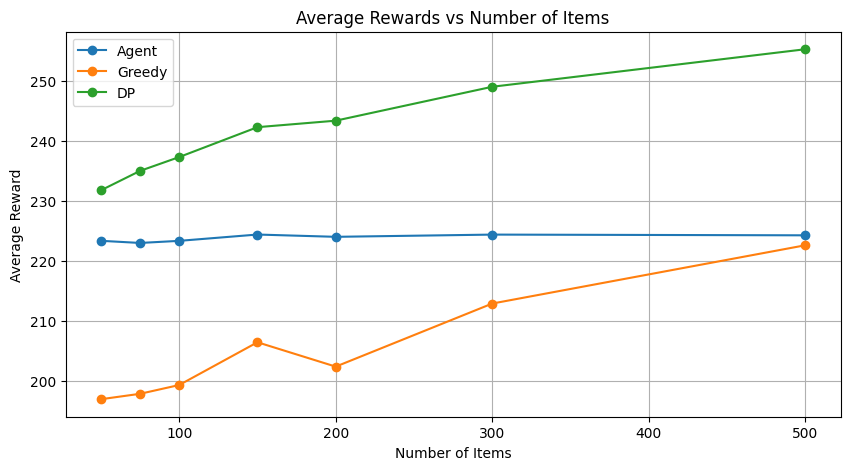

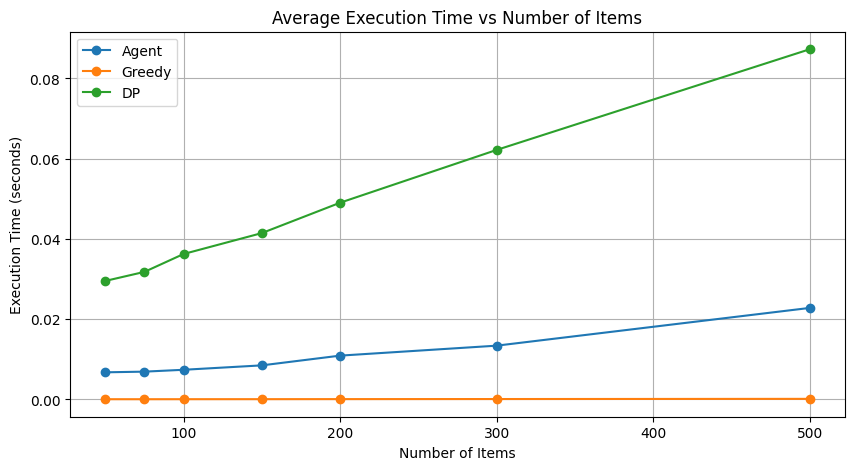

In [35]:
import matplotlib.pyplot as plt

def plot_results(results):
    """
    Function to automatically plot average rewards and execution times
    from the results dictionary.
    
    Args:
        results: Dictionary where keys are N_items and values contain 
                 average rewards and execution times for agent, greedy, and DP.
    """
    # Extract N_items list from the results dictionary
    N_items_list = list(results.keys())

    # Extract data for rewards
    avg_agent_rewards = [results[n]['avg_agent_reward'] for n in N_items_list]
    avg_greedy_rewards = [results[n]['avg_greedy_reward'] for n in N_items_list]
    avg_dp_rewards = [results[n]['avg_dp_reward'] for n in N_items_list]

    # Extract data for execution times
    avg_agent_times = [results[n]['avg_agent_time'] for n in N_items_list]
    avg_greedy_times = [results[n]['avg_greedy_time'] for n in N_items_list]
    avg_dp_times = [results[n]['avg_dp_time'] for n in N_items_list]

    # Create the plot for rewards
    plt.figure(figsize=(10, 5))
    plt.plot(N_items_list, avg_agent_rewards, marker='o', label='Agent')
    plt.plot(N_items_list, avg_greedy_rewards, marker='o', label='Greedy')
    plt.plot(N_items_list, avg_dp_rewards, marker='o', label='DP')

    plt.title("Average Rewards vs Number of Items")
    plt.xlabel("Number of Items")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Create the plot for execution times
    plt.figure(figsize=(10, 5))
    plt.plot(N_items_list, avg_agent_times, marker='o', label='Agent')
    plt.plot(N_items_list, avg_greedy_times, marker='o', label='Greedy')
    plt.plot(N_items_list, avg_dp_times, marker='o', label='DP')

    plt.title("Average Execution Time vs Number of Items")
    plt.xlabel("Number of Items")
    plt.ylabel("Execution Time (seconds)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example of how to call the function
# Assuming `results` is your dictionary after running the experiments
plot_results(results)
